# **FORECASTING YFINANCE - DATA SCIENCE PROYECT**

## **OBJECTIVES**:
- **GENERATE A HISTORICAL DATA SOURCE WITH HOURLY FREQUENCY AND CREATE THE CORRESPONDING TIME SERIES.**

- **SPLIT THE DATA INTO TRAINING, TESTING, AND EVALUATION SETS.**

- **ANALYZE THE TIME SERIES AND DETECT SEASONALITIES, IF ANY. USE ACF AND PACF GRAPHS.**

- **TEST ALL REGRESSION MODELS AND PERFORM THE CORRESPONDING BACKTESTING.**

- **GRAPHICALLY COMPARE THE PERFORMANCE OF ALL MODELS WITH BACKTESTING.**


In [74]:
# DATA
import pandas as pd
import yfinance as yf

In [75]:
# GRAPHS
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size':8})

In [76]:
# REGRESSORS
import xgboost
import lightgbm
import catboost
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [77]:
# FORECAST ALGORITHMS
import skforecast
import sklearn
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import backtesting_forecaster
import shap
shap.initjs()

In [78]:
# WARNINGS
import warnings
warnings.filterwarnings('once')
print(f"Versión skforecast: {skforecast.__version__}")
print(f"Versión lightgbm: {lightgbm.__version__}")
print(f"Versión xgboost: {xgboost.__version__}")
print(f"Versión catboost: {catboost.__version__}")
print(f"Versión scikit-learn: {sklearn.__version__}")

Versión skforecast: 0.12.0
Versión lightgbm: 4.3.0
Versión xgboost: 2.0.3
Versión catboost: 1.2.5
Versión scikit-learn: 1.4.1.post1


## **DATA SOURCE**

In [79]:
# OBTENEMOS LOS DATOS EN PERIODO E INTERVALO CORRESPONDIENTE.
def get_data(stock):
    data = yf.download(stock, period = '1y', interval= '1h')
    data.index = pd.to_datetime(data.index)
    data = data.between_time('11:00', '16:00')
    #print(f'Shape de DATA:{data.shape}')
    complete_days = data.groupby(data.index.date).filter(lambda x: len(x) == 6)
    complete_days = complete_days.sort_index()
    #print(f'Shape de DIAS COMPLETOS: {complete_days.shape}')
    datos = complete_days
    datos = datos.asfreq('H')
    #print(f'Shape de DATOS CON FRECUENCIA: {datos.shape}')
    #print(f'Frecuencia de DATOS: {datos.index.freq}')
    columns_with_nulls = datos.columns[datos.isnull().any()]
    #print(f'Columnas con nulos: {columns_with_nulls}')
    for col in columns_with_nulls:
        datos[col].interpolate(method='linear', inplace=True)
        
    return datos

In [80]:
datos = get_data('AMZN.BA')

[*********************100%%**********************]  1 of 1 completed
C:\Users\nicos\AppData\Local\Temp\ipykernel_18224\1007338316.py:11: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

C:\Users\nicos\AppData\Local\Temp\ipykernel_18224\1007338316.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [81]:
datos.tail()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-06-12 12:00:00-03:00,1705.0,1713.0,1700.0,1705.0,1705.0,31839.0
2024-06-12 13:00:00-03:00,1705.0,1706.0,1695.0,1698.5,1698.5,89895.0
2024-06-12 14:00:00-03:00,1698.5,1699.0,1675.0,1680.0,1680.0,50879.0
2024-06-12 15:00:00-03:00,1680.0,1684.5,1661.0,1680.5,1680.5,59239.0
2024-06-12 16:00:00-03:00,1677.0,1700.0,1677.0,1697.5,1697.5,54401.0


## **DATOS TRAN, TEST, VAL**

In [82]:
# PORCENTAJE DE DIVISION DE DATOS
def calculo_train_test_val(datos):
    datos_shape = datos.shape[0]
    a = 100
    b = 75
    cant_datos_train = ((b * datos_shape) / a)

    c = 15
    cant_datos_val = ((c * datos_shape) / a)

    d = 10
    cant_datos_test = ((d * datos_shape) / a)
    return round(cant_datos_train), round(cant_datos_val), round(cant_datos_test)

In [83]:
cant_datos_train, cant_datos_val, cant_datos_test = calculo_train_test_val(datos)
print(cant_datos_train, "Train")
print(cant_datos_test, 'Test')
print(cant_datos_val, 'Val')

6556 Train
874 Test
1311 Val


In [84]:
first = datos.index.min()
last = datos.index.max()
data = datos.loc[first: last]
data_train = data.iloc[:cant_datos_train].copy()
data_val   = data.iloc[cant_datos_train:-cant_datos_test].copy()
data_test  = data.iloc[-cant_datos_test:].copy()

print(
    f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}"
    f"  (n={len(data_train)})"
)
print(
    f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}"
    f"  (n={len(data_val)})"
)
print(
    f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}"
    f"  (n={len(data_test)})")

Train dates      : 2023-06-14 11:00:00-03:00 --- 2024-03-13 14:00:00-03:00  (n=6556)
Validation dates : 2024-03-13 15:00:00-03:00 --- 2024-05-07 06:00:00-03:00  (n=1312)
Test dates       : 2024-05-07 07:00:00-03:00 --- 2024-06-12 16:00:00-03:00  (n=874)


In [85]:
# END VALIDATION & END TRAIN
end_validation = data_val.index.max()
end_validation = end_validation.strftime("%Y-%m-%d-%H-%M")
end_train = data_train.index.max()
end_train = end_train.strftime("%Y-%m-%d-%H-%M")

In [86]:
print(data_val.head(1)) 
print(data_train.tail(1))

                             Open    High     Low   Close  Adj Close   Volume
Datetime                                                                     
2024-03-13 15:00:00-03:00  1305.0  1305.0  1292.0  1298.0     1298.0  42322.0
                             Open    High     Low   Close  Adj Close   Volume
Datetime                                                                     
2024-03-13 14:00:00-03:00  1300.5  1311.0  1299.0  1305.0     1305.0  48726.0


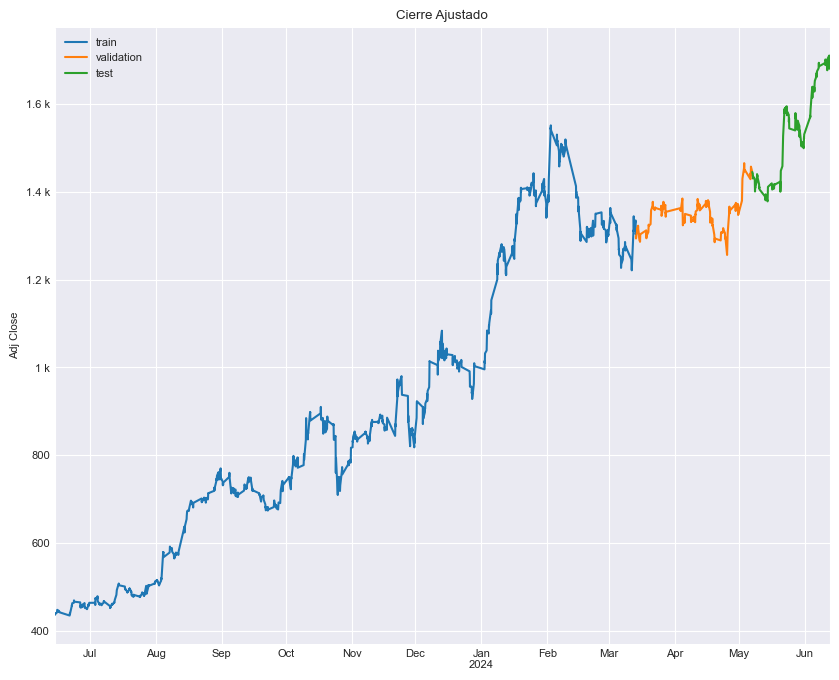

In [87]:
# REPRESENTACION GRAFICO DE TRAIN, TEST Y EVALUATION
fig, ax = plt.subplots(figsize=(10, 8))
data_train['Adj Close'].plot(label='train', ax=ax)
data_val['Adj Close'].plot(label='validation', ax=ax)
data_test['Adj Close'].plot(label='test', ax=ax)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
#ax.set_ylim(bottom=160_000)
ax.set_ylabel('Adj Close')
ax.set_xlabel('')
ax.set_title('Cierre Ajustado')
ax.legend();

***The described time series spans from June 2023 to June 2024, with an hourly frequency.*** 

## **TIME SERIES DESCRIPTION**

In [88]:
# ORGANIZAMOS AÑO, MES Y DIA
data['Año'] = data.index.year
data['Mes'] = data.index.month
data['Dia'] = data.index.day
data['Hora'] = data.index.hour

C:\Users\nicos\AppData\Local\Temp\ipykernel_18224\4071927756.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nicos\AppData\Local\Temp\ipykernel_18224\4071927756.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nicos\AppData\Local\Temp\ipykernel_18224\4071927756.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

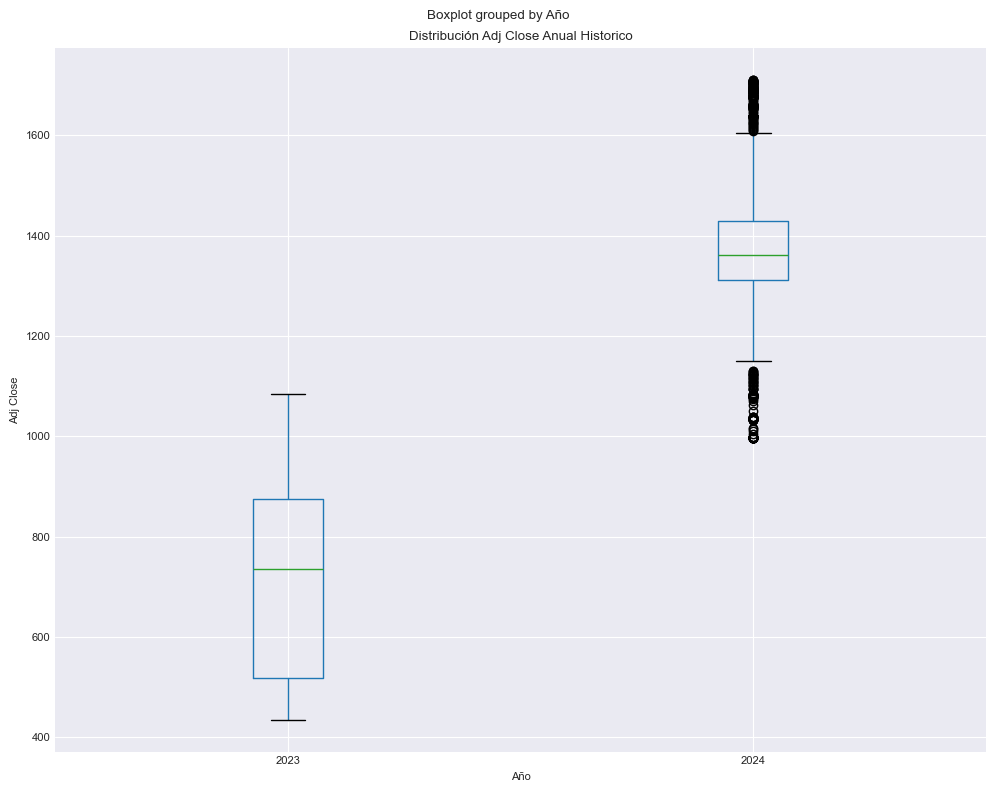

In [89]:
# ESTACIONALIDAD ANUAL
fig, ax = plt.subplots(figsize=(10, 8))
# Crear el gráfico de caja por año
data.boxplot(column='Adj Close', by='Año', ax=ax)
#data.groupby('Año')['Adj Close'].median().plot(style='o-', linewidth=0.8, ax=ax)
# Personalizar el título y las etiquetas
ax.set_ylabel('Adj Close')
ax.set_title('Distribución Adj Close Anual Historico')
ax.set_xlabel('Año')
# Ajustar el diseño
plt.tight_layout()
# Mostrar el gráfico
plt.show()

***In this case, it is not advisable to analyze the annual series since we only have two years and cannot observe seasonalities.***

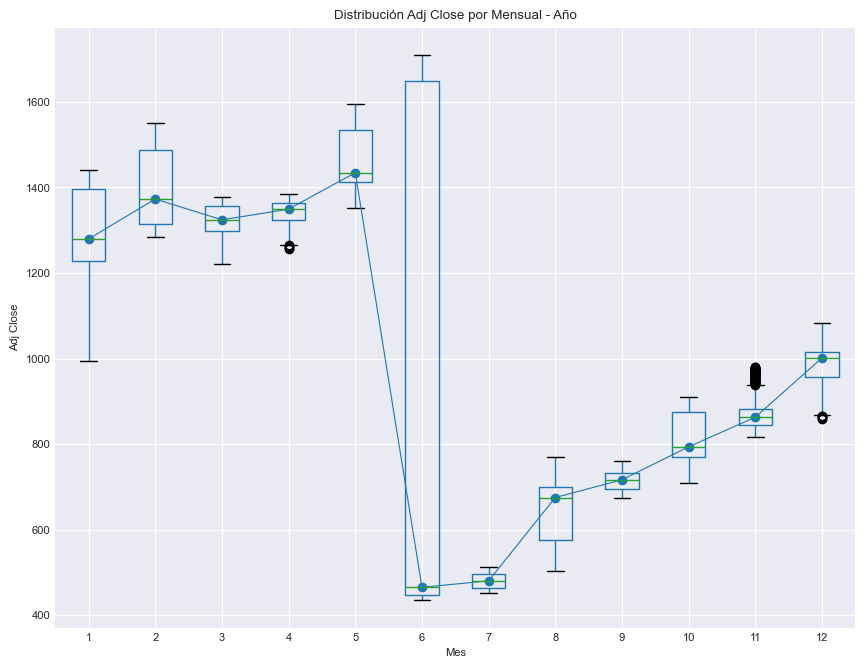

In [90]:
# MENSUAL
fig, ax = plt.subplots(figsize=(10, 8))
data.boxplot(column='Adj Close', by='Mes', ax=ax,)
data.groupby('Mes')['Adj Close'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Adj Close')
ax.set_title('Distribución Adj Close por Mensual - Año')
fig.suptitle('');

***According to the median, we observe a decline in month 6 and an increase thereafter in the adjusted closing.***

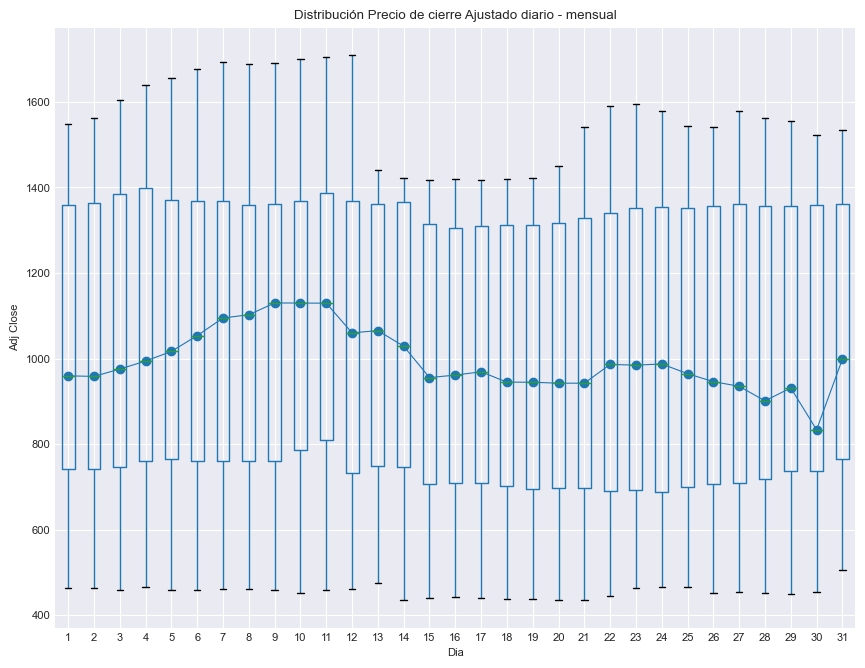

In [91]:
# SEMANAL
fig, ax = plt.subplots(figsize=(10, 8))
data.boxplot(column='Adj Close', by='Dia', ax=ax)
data.groupby('Dia')['Adj Close'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Adj Close')
ax.set_title('Distribución Precio de cierre Ajustado diario - mensual')
fig.suptitle('');

***The most significant peaks occur at the beginning and end of the month.***

C:\Users\nicos\AppData\Local\Temp\ipykernel_18224\3490874500.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



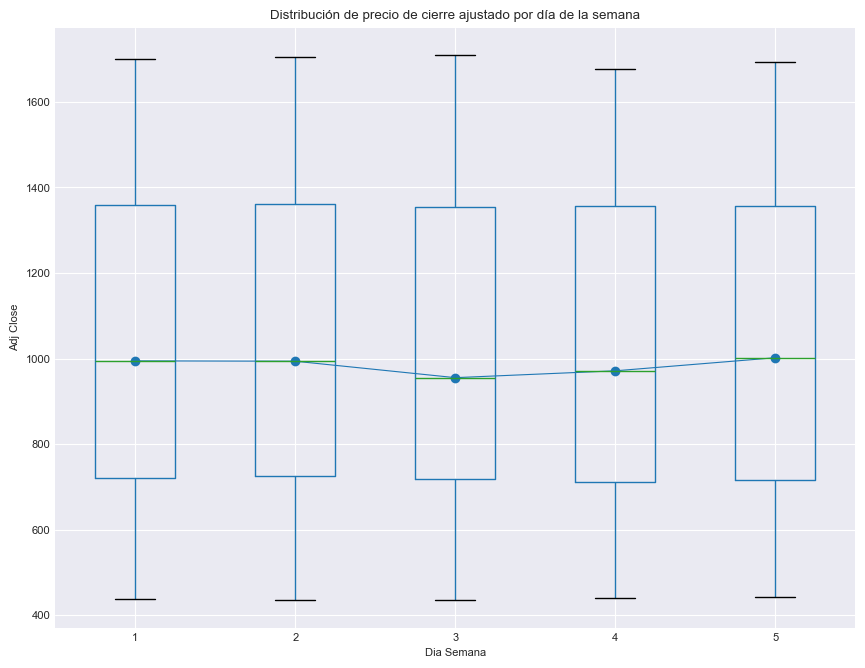

In [92]:
# SOLO TENDREMOS QUE TENER EN CUENTA LOS DIAS DE LUNES A VIERNES
data['Dia Semana'] = data.index.day_of_week + 1
dias_laborales = data[data['Dia Semana'] < 6]
fig, ax = plt.subplots(figsize=(10, 8))
dias_laborales.boxplot(column='Adj Close', by='Dia Semana', ax=ax)
dias_laborales.groupby('Dia Semana')['Adj Close'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Adj Close')
ax.set_title('Distribución de precio de cierre ajustado por día de la semana')
fig.suptitle('');

***According to the median, the first days of the week can be the lowest, although this is not always the case, and this is an obvious observation since we are talking about the median and trying to identify seasonalities rather than trends.***

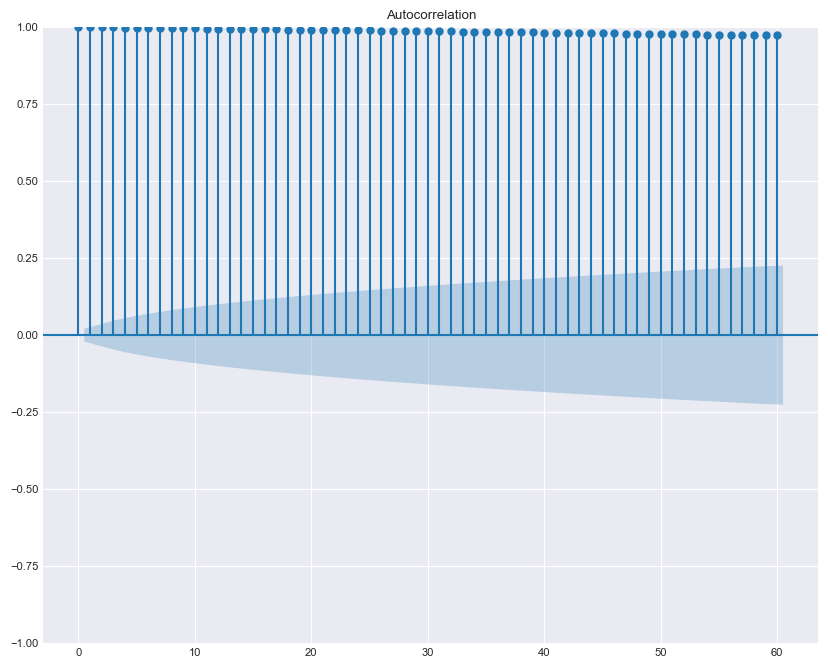

In [93]:
# GRAFICO DE AUTOCORRELACION ACF
fig, ax = plt.subplots(figsize=(10, 8))
plot_acf(data['Adj Close'], ax=ax, lags=60)
plt.show()

***It can be observed that the first ACF graph shows a clear seasonality since its mean value is stable from beginning to end, indicating a clear autocorrelation.***

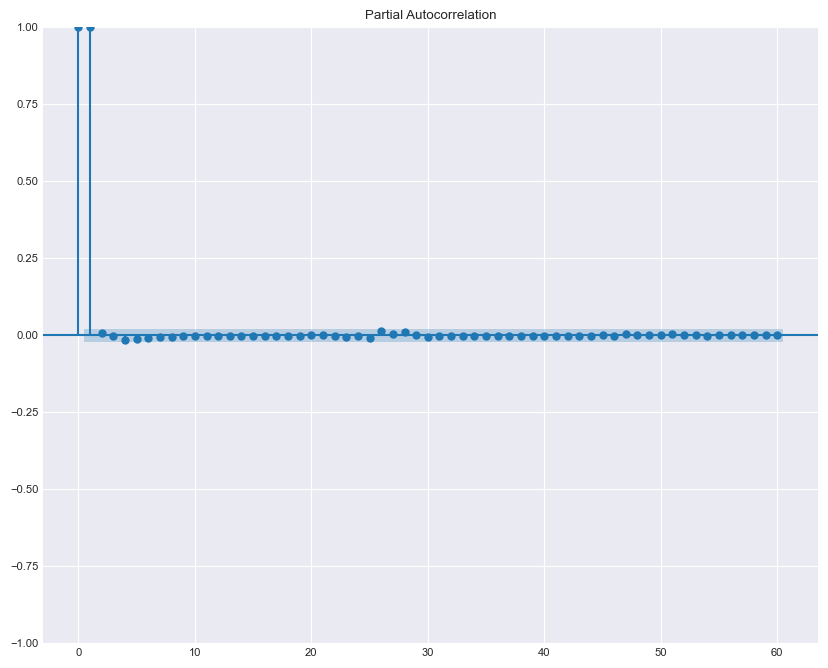

In [94]:
# GRAFICO DE AUTOCORRELACION PACF
fig, ax = plt.subplots(figsize=(10, 8))
plot_pacf(data['Adj Close'], ax=ax, lags=60)
plt.show()

***In the PACF graph, we find a strong correlation in the first two lags, but very little or none in the subsequent lags, indicating an autoregressive term of order one.***

## **FORECASTING WITH ALL REGRESSORS**

**It is recommended to create a baseline model to evaluate whether it is worth applying more complex models in the future. These baseline models currently do not use any regression algorithms, with the aim of employing simple techniques for observation**

In [95]:
forecaster = ForecasterEquivalentDate(
                 offset    = pd.DateOffset(days=1),
                 n_offsets = 1
             )

In [96]:
forecaster.fit(y=data.loc[:end_validation, 'Adj Close'])
forecaster

ForecasterEquivalentDate 
Offset: <DateOffset: days=1> 
Number of offsets: 1 
Aggregation function: mean 
Window size: 24 
Training range: [Timestamp('2023-06-14 11:00:00-0300', tz='America/Argentina/Buenos_Aires'), Timestamp('2024-05-07 03:00:00-0300', tz='America/Argentina/Buenos_Aires')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Creation date: 2024-06-13 14:38:09 
Last fit date: 2024-06-13 14:38:09 
Skforecast version: 0.12.0 
Python version: 3.11.8 
Forecaster id: None 

In [97]:
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['Adj Close'],
                          steps              = 5,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(data.loc[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False,
                          show_progress      = True
                      )

print(f"Backtest error (MAE): {metric}")

  0%|          | 0/176 [00:00<?, ?it/s]

100%|██████████| 176/176 [00:02<00:00, 66.73it/s]

Backtest error (MAE): 17.941931143629798


***A high metric is expected, considering that neither a regressor nor the search for the best hyperparameters according to the regressor was used.***

## **FORECAST AUTOREG + REGRESSRS**

***REGRESSOR: LGBMRegressor***

In [98]:
forecaster_LGBMRegressor = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=15926,verbose=-1),
                 lags      = 7,
             )

In [99]:
forecaster_LGBMRegressor.fit(y=data.loc[:end_validation, 'Adj Close'])
forecaster_LGBMRegressor

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=15926, verbose=-1) 
Lags: [1 2 3 4 5 6 7] 
Transformer for y: None 
Transformer for exog: None 
Window size: 7 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2023-06-14 11:00:00-0300', tz='America/Argentina/Buenos_Aires'), Timestamp('2024-05-07 03:00:00-0300', tz='America/Argentina/Buenos_Aires')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, '

In [100]:
metrica_LGBMRegressor, predicciones_LGBMRegressor = backtesting_forecaster(
                            forecaster         = forecaster_LGBMRegressor,
                            y                  = data['Adj Close'],
                            steps              = 5,
                            metric             = 'mean_absolute_error',
                            initial_train_size = len(data.loc[:end_validation]),
                            refit              = False,
                            n_jobs             = 'auto',
                            verbose            = False,
                            show_progress      = True
                        )

print(f"Backtest error (MAE): {metrica_LGBMRegressor}")

100%|██████████| 176/176 [00:03<00:00, 56.28it/s]


Backtest error (MAE): 41.91522188824267


**REGRESSOR: LinearRegressor**

In [101]:
forecaster_LinearRegression = ForecasterAutoreg(
                 regressor = LinearRegression(),
                 lags      = 7,
             )

In [102]:
forecaster_LinearRegression.fit(y=data.loc[:end_validation, 'Adj Close'])
forecaster_LinearRegression

ForecasterAutoreg 
Regressor: LinearRegression() 
Lags: [1 2 3 4 5 6 7] 
Transformer for y: None 
Transformer for exog: None 
Window size: 7 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2023-06-14 11:00:00-0300', tz='America/Argentina/Buenos_Aires'), Timestamp('2024-05-07 03:00:00-0300', tz='America/Argentina/Buenos_Aires')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False} 
fit_kwargs: {} 
Creation date: 2024-06-13 14:38:16 
Last fit date: 2024-06-13 14:38:17 
Skforecast version: 0.12.0 
Python version: 3.11.8 
Forecaster id: None 

In [103]:
metrica_LinearRegressor, predicciones_LinearRegressor = backtesting_forecaster(
                            forecaster         = forecaster_LinearRegression,
                            y                  = data['Adj Close'],
                            steps              = 5,
                            metric             = 'mean_absolute_error',
                            initial_train_size = len(data.loc[:end_validation]),
                            refit              = False,
                            n_jobs             = 'auto',
                            verbose            = False,
                            show_progress      = True
                        )

print(f"Backtest error (MAE): {metrica_LinearRegressor}")

100%|██████████| 176/176 [00:00<00:00, 201.50it/s]


Backtest error (MAE): 3.18453014642576


***REGRESSOR: RandomForestRegressor***

In [104]:
forecaster_RandomForestRegressor = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=15926,verbose=0),
                 lags      = 7,
             )

In [105]:
forecaster_RandomForestRegressor.fit(y=data.loc[:end_validation, 'Adj Close'])
forecaster_RandomForestRegressor

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=15926) 
Lags: [1 2 3 4 5 6 7] 
Transformer for y: None 
Transformer for exog: None 
Window size: 7 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2023-06-14 11:00:00-0300', tz='America/Argentina/Buenos_Aires'), Timestamp('2024-05-07 03:00:00-0300', tz='America/Argentina/Buenos_Aires')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 15926, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Crea

In [106]:
metrica_RandomForestRegressor, predicciones_RandomForestRegressor = backtesting_forecaster(
                            forecaster         = forecaster_RandomForestRegressor,
                            y                  = data['Adj Close'],
                            steps              = 5,
                            metric             = 'mean_absolute_error',
                            initial_train_size = len(data.loc[:end_validation]),
                            refit              = False,
                            n_jobs             = 'auto',
                            verbose            = False,
                            show_progress      = True
                        )

print(f"Backtest error (MAE): {metrica_RandomForestRegressor}")

100%|██████████| 176/176 [00:25<00:00,  6.88it/s]

Backtest error (MAE): 40.885486290968466


***REGRESSOR: GradientBoostingRegressor***

In [107]:
forecaster_GradientBoostingRegressor = ForecasterAutoreg(
                 regressor = GradientBoostingRegressor(random_state=15926,verbose=0),
                 lags      = 7,
             )

In [108]:
forecaster_GradientBoostingRegressor.fit(y=data.loc[:end_validation, 'Adj Close'])
forecaster_GradientBoostingRegressor

ForecasterAutoreg 
Regressor: GradientBoostingRegressor(random_state=15926) 
Lags: [1 2 3 4 5 6 7] 
Transformer for y: None 
Transformer for exog: None 
Window size: 7 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2023-06-14 11:00:00-0300', tz='America/Argentina/Buenos_Aires'), Timestamp('2024-05-07 03:00:00-0300', tz='America/Argentina/Buenos_Aires')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 15926, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction

In [109]:
metrica_GradientBoostingRegressor, predicciones_GradientBoostingRegressor = backtesting_forecaster(
                            forecaster         = forecaster_GradientBoostingRegressor,
                            y                  = data['Adj Close'],
                            steps              = 5,
                            metric             = 'mean_absolute_error',
                            initial_train_size = len(data.loc[:end_validation]),
                            refit              = False,
                            n_jobs             = 'auto',
                            verbose            = False,
                            show_progress      = True
                        )

print(f"Backtest error (MAE): {metrica_GradientBoostingRegressor}")

100%|██████████| 176/176 [00:01<00:00, 125.52it/s]

Backtest error (MAE): 40.78465987414889


***REGRESSOR: AdaBoostRegressor***

In [110]:
forecaster_AdaBoostRegressor = ForecasterAutoreg(
                 regressor = AdaBoostRegressor(random_state=15926),
                 lags      = 7,
             )

In [111]:
forecaster_AdaBoostRegressor.fit(y=data.loc[:end_validation, 'Adj Close'])
forecaster_AdaBoostRegressor

c:\Users\nicos\anaconda3\envs\Market-Camp\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning:

Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.



ForecasterAutoreg 
Regressor: AdaBoostRegressor(random_state=15926) 
Lags: [1 2 3 4 5 6 7] 
Transformer for y: None 
Transformer for exog: None 
Window size: 7 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2023-06-14 11:00:00-0300', tz='America/Argentina/Buenos_Aires'), Timestamp('2024-05-07 03:00:00-0300', tz='America/Argentina/Buenos_Aires')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: {'estimator': None, 'learning_rate': 1.0, 'loss': 'linear', 'n_estimators': 50, 'random_state': 15926} 
fit_kwargs: {} 
Creation date: 2024-06-13 14:39:31 
Last fit date: 2024-06-13 14:39:34 
Skforecast version: 0.12.0 
Python version: 3.11.8 
Forecaster id: None 

In [112]:
metrica_AdaBoostRegressor, predicciones_AdaBoostRegressor = backtesting_forecaster(
                            forecaster         = forecaster_AdaBoostRegressor,
                            y                  = data['Adj Close'],
                            steps              = 5,
                            metric             = 'mean_absolute_error',
                            initial_train_size = len(data.loc[:end_validation]),
                            refit              = False,
                            n_jobs             = 'auto',
                            verbose            = False,
                            show_progress      = True
                        )

print(f"Backtest error (MAE): {metrica_AdaBoostRegressor}")

100%|██████████| 176/176 [00:15<00:00, 11.00it/s]

Backtest error (MAE): 79.14213177010546


***REGRESSOR: SVR***

In [113]:
forecaster_SVR = ForecasterAutoreg(
                 regressor = SVR(),
                 lags      = 7,
             )

In [114]:
forecaster_SVR.fit(y=data.loc[:end_validation, 'Adj Close'])
forecaster_SVR

ForecasterAutoreg 
Regressor: SVR() 
Lags: [1 2 3 4 5 6 7] 
Transformer for y: None 
Transformer for exog: None 
Window size: 7 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2023-06-14 11:00:00-0300', tz='America/Argentina/Buenos_Aires'), Timestamp('2024-05-07 03:00:00-0300', tz='America/Argentina/Buenos_Aires')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False} 
fit_kwargs: {} 
Creation date: 2024-06-13 14:39:52 
Last fit date: 2024-06-13 14:40:00 
Skforecast version: 0.12.0 
Python version: 3.11.8 
Forecaster id: None 

In [115]:
metrica_SVR, predicciones_SVR = backtesting_forecaster(
                            forecaster         = forecaster_SVR,
                            y                  = data['Adj Close'],
                            steps              = 5,
                            metric             = 'mean_absolute_error',
                            initial_train_size = len(data.loc[:end_validation]),
                            refit              = False,
                            n_jobs             = 'auto',
                            verbose            = False,
                            show_progress      = True
                        )

print(f"Backtest error (MAE): {metrica_SVR}")

100%|██████████| 176/176 [00:02<00:00, 73.78it/s]

Backtest error (MAE): 154.54817855382296


***REGRESSOR: XGBRegressor***

In [116]:
forecaster_XGBRegressor = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=15926),
                 lags      = 7,
             )

In [117]:
forecaster_XGBRegressor.fit(y=data.loc[:end_validation, 'Adj Close'])
forecaster_XGBRegressor

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=15926, ...) 
Lags: [1 2 3 4 5 6 7] 
Transformer for y: None 
Transformer for exog: None 
Window size: 7 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogen

In [118]:
metrica_XGBRegressor, predicciones_XGBRegressor = backtesting_forecaster(
                            forecaster         = forecaster_XGBRegressor,
                            y                  = data['Adj Close'],
                            steps              = 5,
                            metric             = 'mean_absolute_error',
                            initial_train_size = len(data.loc[:end_validation]),
                            refit              = False,
                            n_jobs             = 'auto',
                            verbose            = False,
                            show_progress      = True
                        )

print(f"Backtest error (MAE): {metrica_XGBRegressor}")

100%|██████████| 176/176 [00:01<00:00, 112.53it/s]


Backtest error (MAE): 40.31690162070607


***REGRESSOR: CatBoostRegressor***

In [119]:
forecaster_CatBoostRegressor = ForecasterAutoreg(
                 regressor = CatBoostRegressor(random_state=15926, verbose=0),
                 lags      = 7,
             )

In [120]:
forecaster_CatBoostRegressor.fit(y=data.loc[:end_validation, 'Adj Close'])
forecaster_CatBoostRegressor

ForecasterAutoreg 
Regressor: <catboost.core.CatBoostRegressor object at 0x00000244D553D950> 
Lags: [1 2 3 4 5 6 7] 
Transformer for y: None 
Transformer for exog: None 
Window size: 7 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2023-06-14 11:00:00-0300', tz='America/Argentina/Buenos_Aires'), Timestamp('2024-05-07 03:00:00-0300', tz='America/Argentina/Buenos_Aires')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: {'loss_function': 'RMSE', 'verbose': 0, 'random_state': 15926} 
fit_kwargs: {} 
Creation date: 2024-06-13 14:40:25 
Last fit date: 2024-06-13 14:40:36 
Skforecast version: 0.12.0 
Python version: 3.11.8 
Forecaster id: None 

In [121]:
metrica_CatBoostRegressor, predicciones_CatBoostRegressor = backtesting_forecaster(
                            forecaster         = forecaster_CatBoostRegressor,
                            y                  = data['Adj Close'],
                            steps              = 5,
                            metric             = 'mean_absolute_error',
                            initial_train_size = len(data.loc[:end_validation]),
                            refit              = False,
                            n_jobs             = 'auto',
                            verbose            = False,
                            show_progress      = True
                        )

print(f"Backtest error (MAE): {metrica_CatBoostRegressor}")

100%|██████████| 176/176 [00:04<00:00, 38.84it/s]


Backtest error (MAE): 43.39212174182343


**REGRESSOR: DecisionTreeRegressor**

In [122]:
forecaster_DecisionTreeRegressor = ForecasterAutoreg(
                 regressor = DecisionTreeRegressor(random_state=15926),
                 lags      = 7,
             )

In [123]:
forecaster_DecisionTreeRegressor.fit(y=data.loc[:end_validation, 'Adj Close'])
forecaster_DecisionTreeRegressor

ForecasterAutoreg 
Regressor: DecisionTreeRegressor(random_state=15926) 
Lags: [1 2 3 4 5 6 7] 
Transformer for y: None 
Transformer for exog: None 
Window size: 7 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2023-06-14 11:00:00-0300', tz='America/Argentina/Buenos_Aires'), Timestamp('2024-05-07 03:00:00-0300', tz='America/Argentina/Buenos_Aires')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 15926, 'splitter': 'best'} 
fit_kwargs: {} 
Creation date: 2024-06-13 14:40:52 
Last fit date: 2024-06-13 14:40:53 
Skforecast version: 0.12.0 
Python version:

In [124]:
metrica_DecisionTreeRegressor, predicciones_DecisionTreeRegressor = backtesting_forecaster(
                            forecaster         = forecaster_DecisionTreeRegressor,
                            y                  = data['Adj Close'],
                            steps              = 5,
                            metric             = 'mean_absolute_error',
                            initial_train_size = len(data.loc[:end_validation]),
                            refit              = False,
                            n_jobs             = 'auto',
                            verbose            = False,
                            show_progress      = True
                        )

print(f"Backtest error (MAE): {metrica_DecisionTreeRegressor}")

100%|██████████| 176/176 [00:01<00:00, 101.86it/s]


Backtest error (MAE): 41.262937707605936


In [125]:
data_dict = {'LinearRegression':metrica_LinearRegressor, 'DecisionTreeRegressor':metrica_DecisionTreeRegressor,
             'RandomForestRegressor':metrica_RandomForestRegressor, 'GradientBoostingRegressor':metrica_GradientBoostingRegressor,
             'AdaBoostRegressor':metrica_AdaBoostRegressor, 'SVR':metrica_SVR, 'LGBMRegressor':metrica_LGBMRegressor,
             'CatBoostRegressor':metrica_CatBoostRegressor, 'XGBRegressor':metrica_XGBRegressor}

In [126]:
# CREAR DATAFRAME CON TODOS LOS RESULTADOS Y REALIZAR GRAFICO, LUEGO ESTARIA BUENO HACER LO MISMO PERO CON AUTOREGDIRECT
serie_metrics = pd.Series(data_dict)
df_regs_autoreg = pd.DataFrame(serie_metrics)
df_regs_autoreg = df_regs_autoreg.rename(columns={0:'Metricas'})
df_regs_autoreg = df_regs_autoreg.reset_index()
df_regs_autoreg = df_regs_autoreg.rename(columns={'index':'Regresores'})
df_regs_autoreg

,Regresores,Metricas
0,LinearRegression,3.184530
1,DecisionTreeRegressor,41.262938
2,RandomForestRegressor,40.885486
3,GradientBoostingRegressor,40.784660
4,AdaBoostRegressor,79.142132
5,SVR,154.548179
6,LGBMRegressor,41.915222
7,CatBoostRegressor,43.392122
8,XGBRegressor,40.316902


In [127]:
fig = px.bar(df_regs_autoreg.sort_values(by='Metricas', ascending=True), x='Regresores', y='Metricas', color='Metricas',
             labels={'Metricas':'MAE de Regresores'}, height=400, color_continuous_scale='Viridis')
fig.show()

C:\Users\nicos\AppData\Local\Temp\ipykernel_18224\3692279582.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




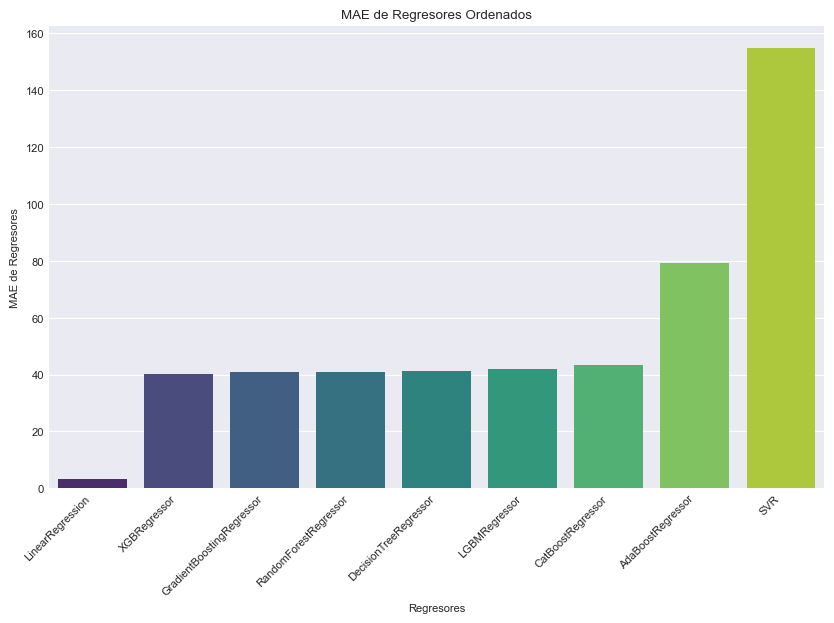

In [128]:
df_sorted = df_regs_autoreg.sort_values(by='Metricas', ascending=True)

plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=df_sorted, x='Regresores', y='Metricas', palette='viridis')

# Etiquetas del gráfico
barplot.set_xlabel('Regresores')
barplot.set_ylabel('MAE de Regresores')
barplot.set_title('MAE de Regresores Ordenados')
plt.xticks(rotation=45, ha='right')
plt.show()

## **FORECAST AUTOREG DIRECT + REGRESSORS**

**REGRESSOR: LGBMRegressor**

In [129]:
forecaster_autoreg_direct_LGBMRegressor = ForecasterAutoregDirect(
                 regressor = LGBMRegressor(random_state=15926,verbose=-1),
                 lags      = 7,
                 steps     = 5
             )

forecaster_autoreg_direct_LGBMRegressor.fit(y=data.loc[:end_validation, 'Adj Close'])
forecaster_autoreg_direct_LGBMRegressor

metrica_autoreg_direct_LGBMRegressor, predicciones_autoreg_direct_LGBMRegressor = backtesting_forecaster(
                            forecaster         = forecaster_autoreg_direct_LGBMRegressor,
                            y                  = data['Adj Close'],
                            steps              = 5,
                            metric             = 'mean_absolute_error',
                            initial_train_size = len(data.loc[:end_validation]),
                            refit              = False,
                            n_jobs             = 'auto',
                            verbose            = False,
                            show_progress      = True
                        )

print(f"Backtest error (MAE): {metrica_autoreg_direct_LGBMRegressor}")

100%|██████████| 176/176 [00:11<00:00, 15.52it/s]

Backtest error (MAE): 42.7905982085022


**REGRESSOR: LinearRegression**

In [130]:
forecaster_autoreg_direct_LinearRegression = ForecasterAutoregDirect(
                 regressor = LinearRegression(),
                 lags      = 7,
                 steps     = 5
             )
forecaster_autoreg_direct_LinearRegression.fit(y=data.loc[:end_validation, 'Adj Close'])
forecaster_autoreg_direct_LinearRegression

metrica_autoreg_direct_LinearRegressor, predicciones_autoreg_direct_LinearRegressor = backtesting_forecaster(
                            forecaster         = forecaster_autoreg_direct_LinearRegression,
                            y                  = data['Adj Close'],
                            steps              = 5,
                            metric             = 'mean_absolute_error',
                            initial_train_size = len(data.loc[:end_validation]),
                            refit              = False,
                            n_jobs             = 'auto',
                            verbose            = False,
                            show_progress      = True
                        )

print(f"Backtest error (MAE): {metrica_autoreg_direct_LinearRegressor}")

100%|██████████| 176/176 [00:01<00:00, 170.73it/s]

Backtest error (MAE): 3.1705082105973204


**REGRESSOR: RandomForestRegressor**

In [131]:
forecaster_autoreg_direct_RandomForestRegressor = ForecasterAutoregDirect(
                 regressor = RandomForestRegressor(random_state=15926,verbose=0),
                 lags      = 7,
                 steps     = 5
             )

forecaster_autoreg_direct_RandomForestRegressor.fit(y=data.loc[:end_validation, 'Adj Close'])
#forecaster_autoreg_direct_RandomForestRegressor

metrica_autoreg_direct_RandomForestRegressor, predicciones_autoreg_direct_RandomForestRegressor = backtesting_forecaster(
                            forecaster         = forecaster_autoreg_direct_RandomForestRegressor,
                            y                  = data['Adj Close'],
                            steps              = 5,
                            metric             = 'mean_absolute_error',
                            initial_train_size = len(data.loc[:end_validation]),
                            refit              = False,
                            n_jobs             = 'auto',
                            verbose            = False,
                            show_progress      = True
                        )

print(f"Backtest error (MAE): {metrica_autoreg_direct_RandomForestRegressor}")

100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Backtest error (MAE): 40.927575549721716


**REGRESSOR: GradientBoostingRegressor**

In [132]:
forecaster_autoreg_direct_GradientBoostingRegressor = ForecasterAutoregDirect(
                 regressor = GradientBoostingRegressor(random_state=15926,verbose=0),
                 lags      = 7,
                 steps     = 5
             )

forecaster_autoreg_direct_GradientBoostingRegressor.fit(y=data.loc[:end_validation, 'Adj Close'])
#forecaster_autoreg_direct_GradientBoostingRegressor

metrica_autoreg_direct_GradientBoostingRegressor, predicciones_autoreg_direct_GradientBoostingRegressor = backtesting_forecaster(
                            forecaster         = forecaster_autoreg_direct_GradientBoostingRegressor,
                            y                  = data['Adj Close'],
                            steps              = 5,
                            metric             = 'mean_absolute_error',
                            initial_train_size = len(data.loc[:end_validation]),
                            refit              = False,
                            n_jobs             = 'auto',
                            verbose            = False,
                            show_progress      = True
                        )

print(f"Backtest error (MAE): {metrica_autoreg_direct_GradientBoostingRegressor}")

100%|██████████| 176/176 [00:04<00:00, 39.07it/s]


Backtest error (MAE): 41.15464766946177


**REGRESSOR: AdaBoostRegressor**

In [133]:
forecaster_autoreg_direct_AdaBoostRegressor = ForecasterAutoregDirect(
                 regressor = AdaBoostRegressor(random_state=15926),
                 lags      = 7,
                 steps     = 5
             )

forecaster_autoreg_direct_AdaBoostRegressor.fit(y=data.loc[:end_validation, 'Adj Close'])
#forecaster_autoreg_direct_AdaBoostRegressor

metrica_autoreg_direct_AdaBoostRegressor, predicciones_autoreg_direct_AdaBoostRegressor = backtesting_forecaster(
                            forecaster         = forecaster_autoreg_direct_AdaBoostRegressor,
                            y                  = data['Adj Close'],
                            steps              = 5,
                            metric             = 'mean_absolute_error',
                            initial_train_size = len(data.loc[:end_validation]),
                            refit              = False,
                            n_jobs             = 'auto',
                            verbose            = False,
                            show_progress      = True
                        )

print(f"Backtest error (MAE): {metrica_autoreg_direct_AdaBoostRegressor}")

100%|██████████| 176/176 [00:35<00:00,  4.98it/s]

Backtest error (MAE): 71.76961812366858


**REGRESSOR: SVR**

In [134]:
forecaster_autoreg_direct_SVR = ForecasterAutoregDirect(
                 regressor = SVR(),
                 lags      = 7,
                 steps     = 5
             )

forecaster_autoreg_direct_SVR.fit(y=data.loc[:end_validation, 'Adj Close'])
#forecaster_autoreg_direct_SVR

metrica_autoreg_direct_SVR, predicciones_autoreg_direct_SVR = backtesting_forecaster(
                            forecaster         = forecaster_autoreg_direct_SVR,
                            y                  = data['Adj Close'],
                            steps              = 5,
                            metric             = 'mean_absolute_error',
                            initial_train_size = len(data.loc[:end_validation]),
                            refit              = False,
                            n_jobs             = 'auto',
                            verbose            = False,
                            show_progress      = True
                        )

print(f"Backtest error (MAE): {metrica_autoreg_direct_SVR}")

100%|██████████| 176/176 [00:05<00:00, 31.26it/s]


Backtest error (MAE): 151.71365869912


**REGRESSOR: XGBMRegressor**

In [135]:
forecaster_autoreg_direct_XGBRegressor = ForecasterAutoregDirect(
                 regressor = XGBRegressor(random_state=15926),
                 lags      = 7,
                 steps     = 5
             )

forecaster_autoreg_direct_XGBRegressor.fit(y=data.loc[:end_validation, 'Adj Close'])
#forecaster_autoreg_direct_XGBRegressor

metrica_autoreg_direct_XGBRegressor, predicciones_autoreg_direct_XGBRegressor = backtesting_forecaster(
                            forecaster         = forecaster_autoreg_direct_XGBRegressor,
                            y                  = data['Adj Close'],
                            steps              = 5,
                            metric             = 'mean_absolute_error',
                            initial_train_size = len(data.loc[:end_validation]),
                            refit              = False,
                            n_jobs             = 'auto',
                            verbose            = False,
                            show_progress      = True
                        )

print(f"Backtest error (MAE): {metrica_autoreg_direct_XGBRegressor}")

100%|██████████| 176/176 [00:02<00:00, 69.88it/s]

Backtest error (MAE): 40.152455187865144


**REGRESSOR: CatBoostRegressor**

In [136]:
forecaster_autoreg_direct_CatBoostRegressor = ForecasterAutoregDirect(
                 regressor = CatBoostRegressor(random_state=15926, verbose=0),
                 lags      = 7,
                 steps     = 5
             )

forecaster_autoreg_direct_CatBoostRegressor.fit(y=data.loc[:end_validation, 'Adj Close'])
#forecaster_autoreg_direct_CatBoostRegressor

metrica_autoreg_direct_CatBoostRegressor, predicciones_autoreg_direct_CatBoostRegressor = backtesting_forecaster(
                            forecaster         = forecaster_autoreg_direct_CatBoostRegressor,
                            y                  = data['Adj Close'],
                            steps              = 5,
                            metric             = 'mean_absolute_error',
                            initial_train_size = len(data.loc[:end_validation]),
                            refit              = False,
                            n_jobs             = 'auto',
                            verbose            = False,
                            show_progress      = True
                        )

print(f"Backtest error (MAE): {metrica_autoreg_direct_CatBoostRegressor}")

100%|██████████| 176/176 [00:05<00:00, 32.91it/s]


Backtest error (MAE): 44.004031407798486


**REGRESSOR: DecisionTreeRegressor**

In [137]:
forecaster_autoreg_direct_DecisionTreeRegressor = ForecasterAutoregDirect(
                 regressor = DecisionTreeRegressor(random_state=15926),
                 lags      = 7,
                 steps     = 5
             )

forecaster_autoreg_direct_DecisionTreeRegressor.fit(y=data.loc[:end_validation, 'Adj Close'])
#forecaster_autoreg_direct_DecisionTreeRegressor

metrica_autoreg_direct_DecisionTreeRegressor, predicciones_autoreg_direct_DecisionTreeRegressor = backtesting_forecaster(
                            forecaster         = forecaster_autoreg_direct_DecisionTreeRegressor,
                            y                  = data['Adj Close'],
                            steps              = 5,
                            metric             = 'mean_absolute_error',
                            initial_train_size = len(data.loc[:end_validation]),
                            refit              = False,
                            n_jobs             = 'auto',
                            verbose            = False,
                            show_progress      = True
                        )

print(f"Backtest error (MAE): {metrica_autoreg_direct_DecisionTreeRegressor}")

100%|██████████| 176/176 [00:01<00:00, 135.68it/s]

Backtest error (MAE): 41.973729055367976


In [138]:
data_dict_autoreg_direct = {'LinearRegression':metrica_autoreg_direct_LinearRegressor, 'DecisionTreeRegressor':metrica_autoreg_direct_DecisionTreeRegressor,
             'RandomForestRegressor':metrica_autoreg_direct_RandomForestRegressor, 'GradientBoostingRegressor':metrica_autoreg_direct_GradientBoostingRegressor,
             'AdaBoostRegressor':metrica_autoreg_direct_AdaBoostRegressor, 'SVR':metrica_autoreg_direct_SVR, 'LGBMRegressor':metrica_autoreg_direct_LGBMRegressor,
             'CatBoostRegressor':metrica_autoreg_direct_CatBoostRegressor, 'XGBRegressor':metrica_autoreg_direct_XGBRegressor}

In [139]:
# CREAR DATAFRAME CON TODOS LOS RESULTADOS Y REALIZAR GRAFICO, LUEGO ESTARIA BUENO HACER LO MISMO PERO CON AUTOREGDIRECT
serie_metrics_autoreg_direct = pd.Series(data_dict_autoreg_direct)
df_regs_autoreg_direct= pd.DataFrame(serie_metrics_autoreg_direct)
df_regs_autoreg_direct = df_regs_autoreg_direct.rename(columns={0:'Metricas'})
df_regs_autoreg_direct = df_regs_autoreg_direct.reset_index()
df_regs_autoreg_direct = df_regs_autoreg_direct.rename(columns={'index':'Regresores AutoregDirect'})
df_regs_autoreg_direct

,Regresores AutoregDirect,Metricas
0,LinearRegression,3.170508
1,DecisionTreeRegressor,41.973729
2,RandomForestRegressor,40.927576
3,GradientBoostingRegressor,41.154648
4,AdaBoostRegressor,71.769618
5,SVR,151.713659
6,LGBMRegressor,42.790598
7,CatBoostRegressor,44.004031
8,XGBRegressor,40.152455


In [140]:
# PLOTLY
fig = px.bar(df_regs_autoreg_direct.sort_values(by='Metricas', ascending=True), x='Regresores AutoregDirect', y='Metricas', color='Metricas',
             labels={'Metricas':'MAE de Regresores'}, height=400, color_continuous_scale='Viridis')
fig.show()

C:\Users\nicos\AppData\Local\Temp\ipykernel_18224\3143658366.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




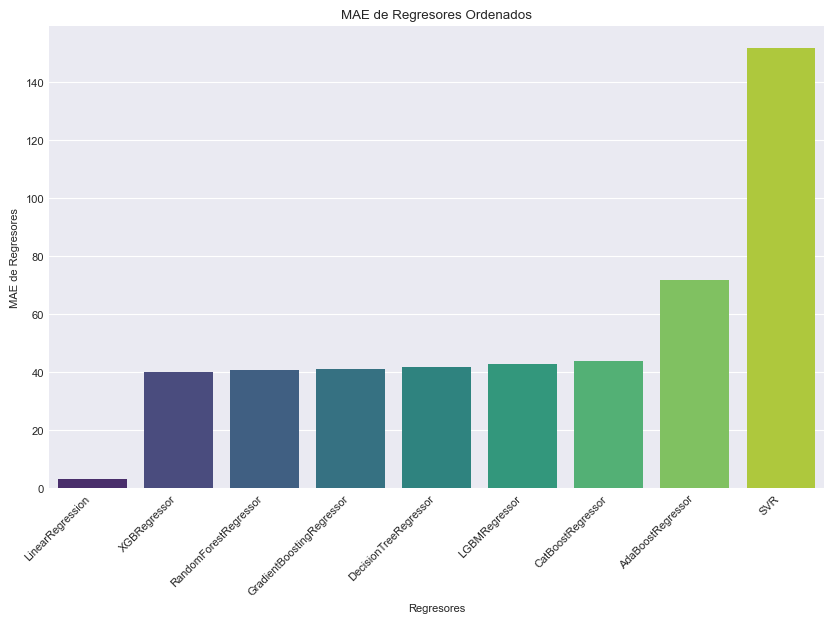

In [141]:
# SEABORN
df_sorted2 = df_regs_autoreg_direct.sort_values(by='Metricas', ascending=True)

plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=df_sorted2, x='Regresores AutoregDirect', y='Metricas', palette='viridis')

barplot.set_xlabel('Regresores')
barplot.set_ylabel('MAE de Regresores')
barplot.set_title('MAE de Regresores Ordenados')
plt.xticks(rotation=45, ha='right')
plt.show()

In [142]:
df_regs_autoreg = df_regs_autoreg.sort_values(by='Metricas', ascending=True)
df_regs_autoreg_direct = df_regs_autoreg_direct.sort_values(by='Metricas', ascending=True)

## **COMPARATIVE - FORECAST AUTOREG & AUTOREG DIRECT**

In [143]:
# PLOTLY
RegresoresAutoreg = df_regs_autoreg['Regresores']
RegresoresAutoregDirect = df_regs_autoreg_direct['Regresores AutoregDirect']
metricas_autoreg = df_regs_autoreg['Metricas']
metricas_autoreg_direct = df_regs_autoreg_direct['Metricas']
fig = go.Figure()
fig.add_trace(go.Bar(
    x=RegresoresAutoreg,
    y=metricas_autoreg,
    name='Forecast Autoreg',
    marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=RegresoresAutoregDirect,
    y=metricas_autoreg_direct,
    name='Forecast Autoreg Direct',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.show()

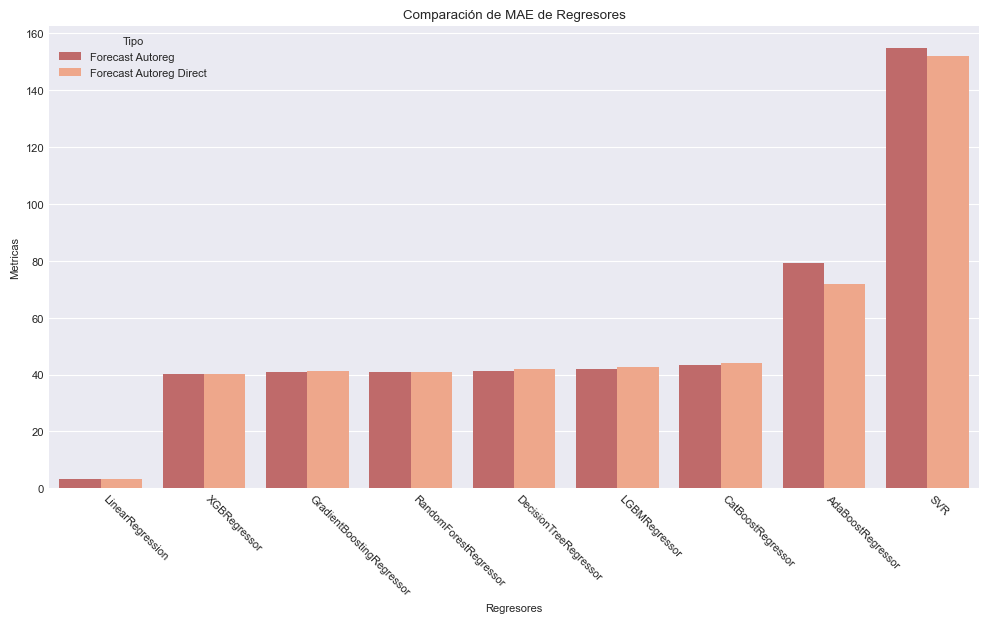

In [144]:
# SEABORN
df_autoreg = df_regs_autoreg[['Regresores', 'Metricas']].copy()
df_autoreg['Tipo'] = 'Forecast Autoreg'

df_autoreg_direct = df_regs_autoreg_direct[['Regresores AutoregDirect', 'Metricas']].copy()
df_autoreg_direct.columns = ['Regresores', 'Metricas']
df_autoreg_direct['Tipo'] = 'Forecast Autoreg Direct'

df_combined = pd.concat([df_autoreg, df_autoreg_direct])

plt.figure(figsize=(12, 6))
barplot = sns.barplot(data=df_combined, x='Regresores', y='Metricas', hue='Tipo', palette={'Forecast Autoreg': 'indianred', 'Forecast Autoreg Direct': 'lightsalmon'})

barplot.set_xlabel('Regresores')
barplot.set_ylabel('Metricas')
barplot.set_title('Comparación de MAE de Regresores')

plt.xticks(rotation=-45, ha='left')

plt.legend(title='Tipo')
plt.show()

***Without working on tuning the model, we see that among the algorithms that can be adjusted with hyperparameters (all except LinearRegression), Random Forest performed the best. What's unique about these forecasting tasks is that after the tuning phase, the model that performs best at this moment may not perform best in hyperparameter selection. Therefore, another model could become the leading candidate in the predictive series.***